<a href="https://colab.research.google.com/github/dora-jpg/Vaccine-Sentiment-Classifier/blob/main/AI2_HM2_feed_forward_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligense II - Homework 2
# 💉Vaccine sentiment classifier using feed-forward neural networks

In this exercise we are going to develop a vaccine sentiment classifier that classifies tweets in pro-vax, anti-vax and neutral classes using feed-forward neural networks. I experimented with: 
- different optimizers (SGD with momentum and nesterov, Adam (with amsgrad) and their learning rate, 
- loss functions (MSELoss and CrossEntropyLoss),
- activation functions (SELU, LeakyReLU, ReLU, tanh), 
- the number of hidden layers and the number of their units (2-4 hidden layers)
- Dropout
- Batch Normalization
- Batch size
- Normalization

For data preprocessing and feature extracting I experimented with:
- GloVe pretrained model: I chose not to do stemming (because words are whole in the pretrained model) or lemmatizing (because it would the change the meaning of some words). I used a simple preprocessing funtion that removes puctuation, html tags and urls. I kept emojis because I noticed that some of them are included in the pretrained glove model. I used the glove.twitter.27B.50d. 
- TF-IDF: I tried lemmatization because it worked well in Homework 1, but ended up having slightly better results with the same preprocessing as the one I used for GloVe. I also experimented with the min_df parameter and noticed that seting it to a slightly lower value to have more features improved the model. 

In this notebook I only present 3 of the models that have good scores (compared to the others) and don't overfit (2 with GloVe and 1 with TF-IDF). 

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries and Read Datasets

In [68]:
import pandas as pd
import numpy as np

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix

# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import matplotlib as mpl
import matplotlib.pyplot as plt

Read train and validation datasets

In [69]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_train_set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_validation_set.csv")

 We don't need the first column of the datasets because it is an index.

In [70]:
# get rid of first column
df_train = df_train.iloc[: , 1:]
df_test = df_test.iloc[: , 1:]

In [71]:
display(df_train.head())
display(df_train.describe())
display(df_train.info())

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


,label
count,15976.000000
mean,0.936592
std,0.930740
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15976 entries, 0 to 15975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   15976 non-null  object
 1   label   15976 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 249.8+ KB


None

In [72]:
display(df_test.head())
display(df_test.describe())
display(df_test.info())

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


,label
count,2282.000000
mean,0.936897
std,0.930960
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2282 non-null   object
 1   label   2282 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.8+ KB


None

## Data Pre-processing

### Data Cleaning


In [73]:
#Check for null values
#In this case there are no missing values, so no action is needed
df_train.isnull().sum()

tweet    0
label    0
dtype: int64

In [74]:
df_test.isnull().sum()

tweet    0
label    0
dtype: int64

In [75]:
import re
import string
from nltk.corpus import stopwords

import nltk
nltk.download("stopwords")

stop_words = stopwords.words("english")

def tweets_cleaning(x, remove_emojis=False, remove_stop_words=True):
    """Apply function to a clean a tweet"""
    x = x.lower().strip()
    # romove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    # remove punctuation
    operator = str.maketrans(' ',' ',string.punctuation)
    x = x.translate(operator)
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if remove_stop_words:
        x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
## APPLY the cleaning function to the text column
df_train['cleanglove_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['cleanglove_tweet'] = df_test['tweet'].apply(tweets_cleaning)

### Separate features from targets

In [77]:
X_train = df_train['cleanglove_tweet']
Y_train = df_train['label'] #Only keep value

X_test = df_test['cleanglove_tweet']
Y_test = df_test['label'] #Only keep value

In [78]:
X_train

0        sip n shop come thru right marjais popularnobo...
1        dont know family take covid19 vaccine anytime ...
2        msignorile immunizations mandatory period okla...
3        president obama spoke favor vaccination childr...
4        myfoxla arizona monitoring hundreds measles li...
                               ...                        
15971    salon u believe antivax nutcases caused measle...
15972    feel parents dont vaccinate kids\r\n\r\nmeasle...
15973          70 preschoolers tested measles simi valley 
15974    finance minister budget offers room procure co...
15975    date vaccines take cdc’s vaccine quiz find vac...
Name: cleanglove_tweet, Length: 15976, dtype: object

In [79]:
X_test

0       user massive surge covid deaths immediately va...
1       required vaccines school parents guardians chi...
2       “kcstar two johnson county children measles  s...
3          nv better states best worst vaccinating kids  
4       nothing like killing w fear mtalyssamilano vac...
                              ...                        
2277    rt abc7 number measles cases reported cali 10y...
2278    evidence points idea measles affects immune sy...
2279    wheres savedyouaclick voxdotcom vaccinate kids...
2280    favorite people autism thats reason bringing b...
2281    coronavirus married couple behind successful p...
Name: cleanglove_tweet, Length: 2282, dtype: object

Overview of label distribution

In [80]:
print("train data")
print("label 0:",Y_train[Y_train== 0].count())
print("label 1:",Y_train[Y_train== 1].count())
print("label 2:",Y_train[Y_train== 2].count())
print("validation data")
print("label 0:",Y_test[Y_test== 0].count())
print("label 1:",Y_test[Y_test== 1].count())
print("label 2:",Y_test[Y_test== 2].count())

train data
label 0: 7458
label 1: 2073
label 2: 6445
validation data
label 0: 1065
label 1: 296
label 2: 921


Label 1 has very few instances so we expect that it has a lower score than the other 2 labels. 

## Features Extraction


### GloVe representation

Load pre-trained GloVe vectors into a dictionary

In [81]:
embeddings_dict = {}
with open("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/glove.twitter.27B.50d.txt", 'r', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embeddings_dict[word]=vector

Find the vector for each word in each tweet and for every tweet keep the average of each dimesion of its words.

Some words do not exist in the pretrained model and in some tweets there isn't any word that matches. So I filled those tweets with zeros.  

In [82]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
def find_glove(text):
  tokens = word_tokenize(text.lower())
  res = [ embeddings_dict[token] for token in tokens if (token in embeddings_dict) ]
  # print([ token for token in tokens if (token not in embeddings_dict) ] )
  if (len(res) == 0):
    res = np.zeros(50)
  else:
    res = np.stack(res, axis=0)
    res = np.average(res, axis=0).flatten()
  return res

df_train['features'] = df_train['cleanglove_tweet'].apply(find_glove)
df_test['features'] = df_test['cleanglove_tweet'].apply(find_glove)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### TF-IDF representation

This is the same function that I used in Homework 1 for lemmatization. In this exercise it did not have better results than the simple preprocessing so I didn't use it.

In [83]:
# Dictionary is created where pos_tag (first letter) are the key values whose values are mapped with the value from wordnet dictionary. 
# We have taken the only first letter as we will use it later in the loop.

# For preprocessing
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# the corpus reader wordnet is imported.
from nltk.corpus import wordnet as wn
# WordNetLemmatizer is imported from wordnet.
from nltk.stem.wordnet import WordNetLemmatizer
# Word tokenize as well as parts of speech tag are imported from nltk.
from nltk import word_tokenize, pos_tag
# Default Dictionary is imported from collections.
from collections import defaultdict

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
import gensim
all_stopwords = gensim.parsing.preprocessing.STOPWORDS
lemmatizer = WordNetLemmatizer()

def lemma_text(text):
  text = text.replace("#", " ")
  tokens = word_tokenize(text.lower())
  text = ' '.join([lemmatizer.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]) # if (token not in all_stopwords and token.isalpha() == True and len(token)>2)
  return text


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [84]:

df_train['cleantfidf_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['cleantfidf_tweet'] = df_test['tweet'].apply(tweets_cleaning)

For the TF-IDF vectorization I used unigrams & bigrams for a better representation of the tweets and connections between words. I tried 0.01, 0.002 and 0.001 for the min_df parameter. 0.01 resulted in very little features that were not enough to represent the dataset well. 0.002 is the value that I worked best in Homework 1, but 0.001 did better in this one.

In [85]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.001, stop_words='english', lowercase=True)

tfidf_vectorizer.fit(df_train['cleantfidf_tweet'])

tfidf_train = tfidf_vectorizer.transform(df_train['cleantfidf_tweet'])
print(tfidf_train.shape)
print(tfidf_vectorizer.get_feature_names_out())
tfidf_test = tfidf_vectorizer.transform(df_test['cleantfidf_tweet'])
print(tfidf_test.shape)

(15976, 1900)
['10' '100' '1000' ... 'yr' 'yrs' 'zero']
(2282, 1900)


## Neural Network using GloVe-4 hidden layers

Import torch

In [86]:
import torch
import torch.nn as nn

Tranform train and test dataframes to tensors so that we can use them in the neural network.

I experimented with feature normalization but it dropped the score to 64.3 from 71.5, so I chose to keep only batch normalization inside the model. 

In [119]:
train_features = np.stack(df_train['features'])

#Normalize values
# train_features = np.stack(df_train['features'])
# train_features = (train_features-train_features.mean())/train_features.std()

#Save in tensors
x = torch.tensor(train_features, dtype=torch.float)
y = torch.tensor(df_train['label'], dtype=torch.float)

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([15976, 50])
y shape: torch.Size([15976])


In [120]:
test_features = np.stack(df_test['features'])
# test_features = (test_features-test_features.mean())/test_features.std()
# display(test_features.mean())
# display(test_features.std())
x_test = torch.tensor(test_features, dtype=torch.float)
y_test = torch.tensor(Y_test, dtype=torch.float)

y_test_3 = np.array(pd.get_dummies(y_test.detach().numpy()))
y_test_3 = torch.tensor(y_test_3, dtype=torch.float)

### Create a Neural Network

In [121]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net, self).__init__()
        
        self.d1 = nn.Dropout(p=0.5)
        self.d2 = nn.Dropout(p=0.4)
        self.d3 = nn.Dropout(p=0.4)
        self.d4 = nn.Dropout(p=0.4)

        self.bn1 = nn.BatchNorm1d(H1)
        self.bn2 = nn.BatchNorm1d(H2)
        self.bn3 = nn.BatchNorm1d(H3)
        self.bn4 = nn.BatchNorm1d(H4)

        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, H4)
        self.linear5 = nn.Linear(H4, D_out)

        self.softmax = nn.Softmax(dim=1);
        self.relu=nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h1 = self.bn1(h1)
        self.relu(h1)
        h1 = self.d1(h1)

        h2 = self.linear2(h1)
        h2 = self.bn2(h2)
        self.relu(h2)
        h2 = self.d2(h2)

        h3 = self.linear3(h2)
        h3 = self.bn3(h3)
        self.relu(h3)
        h3 = self.d3(h3)

        h4 = self.linear4(h3)
        h4 = self.bn4(h4)
        self.relu(h4)
        h4 = self.d4(h4)

        out = self.linear5(h4)
        # out = self.softmax(out)
        return out

In [150]:
np.random.seed(20)
torch.manual_seed(20)

#Define layer sizes
D_in = x.shape[1]
H1 = 1024
H2 = 512
H3 = 128
H4 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.001

#Initialize model, loss, optimizer
model = Net(D_in, H1, H2, H3, H4, D_out)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Initialize dataloader
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

display(model)

Net(
  (d1): Dropout(p=0.5, inplace=False)
  (d2): Dropout(p=0.4, inplace=False)
  (d3): Dropout(p=0.4, inplace=False)
  (d4): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=50, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
)

### Train Network

In [151]:
epoch_loss = []
validation_loss = []
epochs = 15

for epoch in range(epochs):
  model.train()
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    
    y_batch = np.array(pd.get_dummies(y_batch.detach().numpy()))
    y_batch = torch.tensor(y_batch, dtype=torch.float)
    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

  epoch_loss.append(sum(batch_losses)/len(dataloader))
  model.eval()
  y_test_pred = model(x_test)

  val_loss = loss_func(y_test_pred, y_test_3)

  validation_loss.append(val_loss.item())
  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")
    

Epoch   0: Loss = 0.87377
Epoch   1: Loss = 0.79996
Epoch   2: Loss = 0.77461
Epoch   3: Loss = 0.76644
Epoch   4: Loss = 0.75097
Epoch   5: Loss = 0.74848
Epoch   6: Loss = 0.73917
Epoch   7: Loss = 0.73029
Epoch   8: Loss = 0.71982
Epoch   9: Loss = 0.71319
Epoch  10: Loss = 0.70941
Epoch  11: Loss = 0.69968
Epoch  12: Loss = 0.70381
Epoch  13: Loss = 0.69742
Epoch  14: Loss = 0.69138


### Evaluation of the model using recall, precision and f1 metrics

In [152]:
model.eval()
# accuracy = softReg.score(chosen_test, Y_test)
# print("Accuracy = ", accuracy * 100, "%")

y_pred_3 = model(x_test).detach().numpy()
y_pred = np.argmax(y_pred_3, axis=1)

from sklearn.metrics import precision_recall_fscore_support
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred))
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred, average='micro'))

f1 = f1_score(Y_test, y_pred, average=None)
print("F1 score for each class = ", f1 * 100, "%")
f1 = f1_score(Y_test, y_pred, average='micro')
print("F1 score = ", f1 * 100, "%")

from sklearn.metrics import precision_score
print("precision: ", precision_score(Y_test, y_pred, average='weighted'))

from sklearn.metrics import recall_score
print("recall: ", recall_score(Y_test, y_pred, average='micro'))

all in one metrics: precision, recall, f1: (array([0.78238866, 0.48969072, 0.62818182]), array([0.7258216 , 0.32094595, 0.75027144]), array([0.75304433, 0.3877551 , 0.68381989]), array([1065,  296,  921]))
all in one metrics: precision, recall, f1: (0.6831726555652936, 0.6831726555652936, 0.6831726555652936, None)
F1 score for each class =  [75.30443254 38.7755102  68.38198911] %
F1 score =  68.31726555652936 %
precision:  0.6821857297454899
recall:  0.6831726555652936


### Confusion Matrix

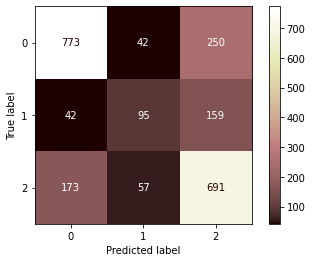

In [153]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, cmap=plt.cm.pink)  
plt.show()

### Learning Curves

[0.8737663929424588, 0.7999635244172717, 0.7746110255756076, 0.7664425902896457, 0.7509668611344837, 0.7484807022034176, 0.7391697754935612, 0.7302907582313295, 0.7198178285644168, 0.7131870370062571, 0.7094097326672266, 0.6996761437446352, 0.7038081496480911, 0.6974177720054747, 0.6913760020619347]
[0.7759827375411987, 0.7497354745864868, 0.7463548183441162, 0.7354224324226379, 0.7353914976119995, 0.7308493852615356, 0.7306616306304932, 0.7253496050834656, 0.7232582569122314, 0.7250297665596008, 0.7181254029273987, 0.7209709882736206, 0.7174991965293884, 0.7169308066368103, 0.7183248996734619]


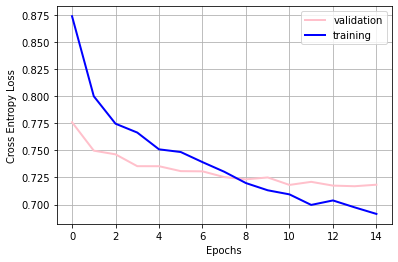

In [154]:
# plot
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()
  

### ROC curve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


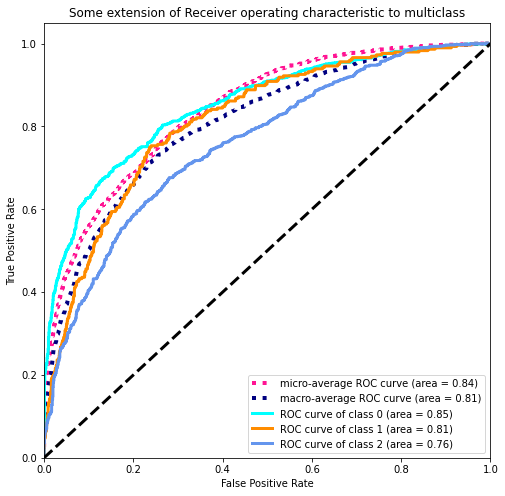

In [155]:
# CODE FROM https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

y_score = y_pred_3
y_test = np.array(pd.get_dummies(Y_test))
n_classes = 3
# print(y_score)
# print(y_test)
# print(n_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
################################################################################

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Neural Network using GloVe-3 hidden layers



In [265]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.d1 = nn.Dropout(p=0.5)
        self.d2 = nn.Dropout(p=0.4)
        self.d3 = nn.Dropout(p=0.4)

        self.bn1 = nn.BatchNorm1d(H1)
        self.bn2 = nn.BatchNorm1d(H2)
        self.bn3 = nn.BatchNorm1d(H3)

        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

        self.softmax = nn.Softmax(dim=1);
        self.relu=nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h1 = self.bn1(h1)
        self.relu(h1)
        h1 = self.d1(h1)

        h2 = self.linear2(h1)
        h2 = self.bn2(h2)
        self.relu(h2)
        h2 = self.d2(h2)

        h3 = self.linear3(h2)
        h3 = self.bn3(h3)
        self.relu(h3)
        h3 = self.d3(h3)

        out = self.linear4(h3)
        # out = self.softmax(out)
        return out

In [266]:
np.random.seed(20)
torch.manual_seed(20)

#Define layer sizes
D_in = x.shape[1]
H1 = 512
H2 = 256
H3 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.001

#Initialize model, loss, optimizer
model = Net(D_in, H1, H2, H3, D_out)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

#Initialize dataloader
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

display(model)

Net(
  (d1): Dropout(p=0.5, inplace=False)
  (d2): Dropout(p=0.4, inplace=False)
  (d3): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=50, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
)

### Train Network

In [267]:
epoch_loss = []
validation_loss = []
epochs = 30

for epoch in range(epochs):
  model.train()
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    
    y_batch = np.array(pd.get_dummies(y_batch.detach().numpy()))
    y_batch = torch.tensor(y_batch, dtype=torch.float)
    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

  epoch_loss.append(sum(batch_losses)/len(dataloader))
  model.eval()
  y_test_pred = model(x_test)

  val_loss = loss_func(y_test_pred, y_test_3)

  validation_loss.append(val_loss.item())
  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")
    

Epoch   0: Loss = 0.89691
Epoch   1: Loss = 0.80528
Epoch   2: Loss = 0.78505
Epoch   3: Loss = 0.77621
Epoch   4: Loss = 0.76470
Epoch   5: Loss = 0.76116
Epoch   6: Loss = 0.75405
Epoch   7: Loss = 0.74024
Epoch   8: Loss = 0.74155
Epoch   9: Loss = 0.73564
Epoch  10: Loss = 0.73292
Epoch  11: Loss = 0.72857
Epoch  12: Loss = 0.72226
Epoch  13: Loss = 0.71802
Epoch  14: Loss = 0.71546
Epoch  15: Loss = 0.71148
Epoch  16: Loss = 0.70828
Epoch  17: Loss = 0.70898
Epoch  18: Loss = 0.70256
Epoch  19: Loss = 0.69654
Epoch  20: Loss = 0.69304
Epoch  21: Loss = 0.69318
Epoch  22: Loss = 0.68574
Epoch  23: Loss = 0.68495
Epoch  24: Loss = 0.68361
Epoch  25: Loss = 0.67546
Epoch  26: Loss = 0.67426
Epoch  27: Loss = 0.67451
Epoch  28: Loss = 0.66438
Epoch  29: Loss = 0.66848


### Evaluation of the model using recall, precision and f1 metrics

In [268]:
model.eval()
# accuracy = softReg.score(chosen_test, Y_test)
# print("Accuracy = ", accuracy * 100, "%")

y_pred_3 = model(x_test).detach().numpy()
y_pred = np.argmax(y_pred_3, axis=1)

from sklearn.metrics import precision_recall_fscore_support
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred))
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred, average='micro'))

f1 = f1_score(Y_test, y_pred, average=None)
print("F1 score for each class = ", f1 * 100, "%")
f1 = f1_score(Y_test, y_pred, average='micro')
print("F1 score = ", f1 * 100, "%")

from sklearn.metrics import precision_score
print("precision: ", precision_score(Y_test, y_pred, average='weighted'))

from sklearn.metrics import recall_score
print("recall: ", recall_score(Y_test, y_pred, average='micro'))

all in one metrics: precision, recall, f1: (array([0.77073171, 0.51785714, 0.62534435]), array([0.74178404, 0.29391892, 0.73941368]), array([0.75598086, 0.375     , 0.67761194]), array([1065,  296,  921]))
all in one metrics: precision, recall, f1: (0.6827344434706398, 0.6827344434706398, 0.6827344434706398, None)
F1 score for each class =  [75.59808612 37.5        67.76119403] %
F1 score =  68.27344434706399 %
precision:  0.6792537823570236
recall:  0.6827344434706398


### Confusion Matrix

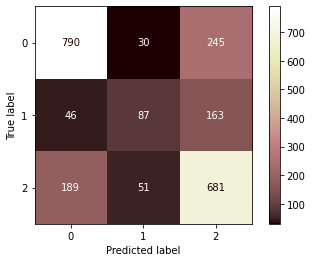

In [269]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, cmap=plt.cm.pink)  
plt.show()

### Learning Curves

[0.896914782032134, 0.8052833193824405, 0.7850512464841207, 0.7762075984288775, 0.7646973965659974, 0.7611585675723969, 0.7540478327917675, 0.7402394319337512, 0.7415549329348973, 0.7356423981606014, 0.7329226552493988, 0.7285672511373248, 0.7222636266360207, 0.7180202773639134, 0.7154628350621178, 0.7114797281840491, 0.7082807213541061, 0.7089791496594747, 0.702555481403593, 0.696543450393374, 0.6930368722431244, 0.693176081256261, 0.6857420537206862, 0.6849527529307774, 0.6836055063066029, 0.6754569155829293, 0.6742629891350156, 0.6745086577203538, 0.6643752313795543, 0.6684782684795441]
[0.7854580283164978, 0.7583250403404236, 0.751770555973053, 0.7437705397605896, 0.7414252161979675, 0.7367034554481506, 0.7333216071128845, 0.7308684587478638, 0.7273510098457336, 0.725547730922699, 0.7280638217926025, 0.723031222820282, 0.7264412045478821, 0.7200399041175842, 0.7246341705322266, 0.7212274670600891, 0.7200638055801392, 0.715599000453949, 0.7157238125801086, 0.7160835266113281, 0.7148

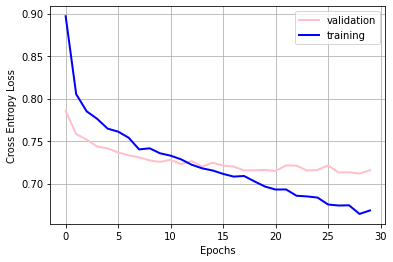

In [270]:
# plot
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()
  

## Neural Network using TF-IDF

In [311]:
#Normalize values
# train_features = np.stack(df_train['features'])
train_features = tfidf_train.toarray()
#Fill NaN values
# train_features = np.stack(df_train['features'])
# train_features = (train_features-train_features.mean())/train_features.std()
#Save in tensors
x = torch.tensor(train_features, dtype=torch.float)
y = torch.tensor(df_train['label'], dtype=torch.float)

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([15976, 1900])
y shape: torch.Size([15976])


In [312]:
# test_features = np.stack(df_test['features'])
test_features = tfidf_test.toarray()
# test_features = (test_features-test_features.mean())/test_features.std()
# display(test_features.mean())
# display(test_features.std())
x_test = torch.tensor(test_features, dtype=torch.float)
y_test = torch.tensor(Y_test, dtype=torch.float)

y_test_3 = np.array(pd.get_dummies(y_test.detach().numpy()))
y_test_3 = torch.tensor(y_test_3, dtype=torch.float)

### Create a Neural Network

In [313]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.d1 = nn.Dropout(p=0.7)
        self.d2 = nn.Dropout(p=0.5)
        self.d3 = nn.Dropout(p=0.3)

        self.bn1 = nn.BatchNorm1d(H1)
        self.bn2 = nn.BatchNorm1d(H2)
        self.bn3 = nn.BatchNorm1d(H3)

        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

        self.relu=nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h1 = self.bn1(h1)
        self.relu(h1)
        h1 = self.d1(h1)

        h2 = self.linear2(h1)
        h2 = self.bn2(h2)
        self.relu(h2)
        h2 = self.d2(h2)

        h3 = self.linear3(h2)
        h3 = self.bn3(h3)
        self.relu(h3)
        h3 = self.d3(h3)

        out = self.linear4(h3)
        
        return out

In [319]:
#Define layer sizes
D_in = x.shape[1]
H1 = 256
H2 = 1024
H3 = 256
D_out = 3

#Define Hyperparameters
learning_rate = 0.001

#Initialize model, loss, optimizer
model = Net(D_in, H1, H2, H3, D_out)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Initialize dataloader
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True) #, shuffle=True

display(model)

Net(
  (d1): Dropout(p=0.7, inplace=False)
  (d2): Dropout(p=0.5, inplace=False)
  (d3): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=1900, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
)

### Train Network

In [320]:
epoch_loss = []
validation_loss = []
epochs = 3

for epoch in range(epochs):
  model.train()
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    # print(y_pred)
    y_batch = np.array(pd.get_dummies(y_batch.detach().numpy()))
    y_batch = torch.tensor(y_batch, dtype=torch.float)
    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

  epoch_loss.append(sum(batch_losses)/len(dataloader))
  model.eval()
  y_test_pred = model(x_test)
  # y_test = y_test.type(torch.LongTensor)
  # y_test = torch.tensor(y_test, dtype=torch.float)
  val_loss = loss_func(y_test_pred, y_test_3)
  # print(y_test_pred)
  validation_loss.append(val_loss.item())
  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")
    

Epoch   0: Loss = 0.86442
Epoch   1: Loss = 0.68936
Epoch   2: Loss = 0.61646


### Evaluation of the model using recall, precision and f1 metrics

In [321]:
model.eval()
# accuracy = softReg.score(chosen_test, Y_test)
# print("Accuracy = ", accuracy * 100, "%")

y_pred_3 = model(x_test).detach().numpy()
y_pred = np.argmax(y_pred_3, axis=1)

from sklearn.metrics import precision_recall_fscore_support
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred))
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred, average='weighted'))

f1 = f1_score(Y_test, y_pred, average=None)
print("F1 score for each class = ", f1 * 100, "%")
f1 = f1_score(Y_test, y_pred, average='micro')
print("F1 score = ", f1 * 100, "%")

from sklearn.metrics import precision_score
print("precision: ", precision_score(Y_test, y_pred, average='weighted'))

from sklearn.metrics import recall_score
print("recall: ", recall_score(Y_test, y_pred, average='micro'))

all in one metrics: precision, recall, f1: (array([0.80291971, 0.5229682 , 0.67884615]), array([0.72300469, 0.5       , 0.76655809]), array([0.76086957, 0.51122625, 0.7200408 ]), array([1065,  296,  921]))
all in one metrics: precision, recall, f1: (0.7165317192444526, 0.7116564417177914, 0.7120099168547595, None)
F1 score for each class =  [76.08695652 51.12262522 72.00407955] %
F1 score =  71.16564417177914 %
precision:  0.7165317192444526
recall:  0.7116564417177914


### Confusion Matrix

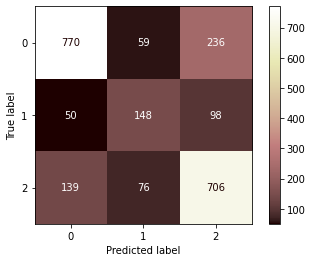

In [322]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, cmap=plt.cm.pink)  
plt.show()

### Learning Curves

[0.8644219476079184, 0.6893580101785206, 0.6164626195317223]
[0.8309535980224609, 0.6827185750007629, 0.681594967842102]


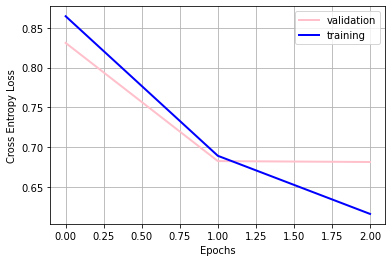

In [323]:
# plot
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()
  

### ROC curve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


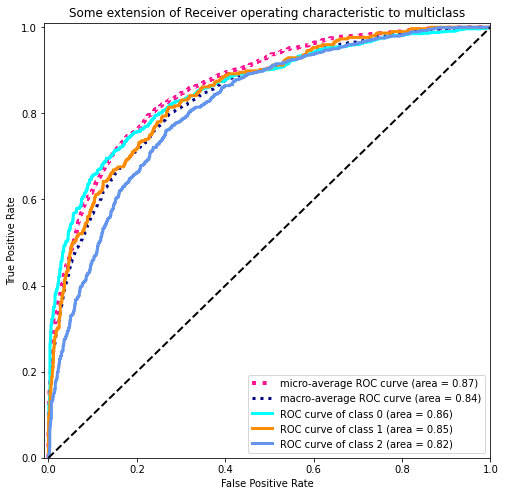

In [324]:
from matplotlib import figure
# CODE FROM https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

y_score = y_pred_3
y_test = np.array(pd.get_dummies(Y_test))
n_classes = 3
# print(y_score)
# print(y_test)
# print(n_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
################################################################################

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=3,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()